In [8]:
import argparse
import yaml
from tqdm import tqdm
import sys

import pickle

import jax
import jax.numpy as jnp
import optax   

import math
import numpy as np
import matplotlib.pyplot as plt

from helpers.data import get_pdf_toy, read_in_data_JAX

# Params and Initialization

### @RADHA, IMPORTANT CHANGE

I made it so mstar is the lowest power of alpha that can appear in either g_star or g_mn.

If mstar = 1, then the 0th row of both matrices correspond to alpha^1 terms.

If mstar = 0, then the 0th row of both matrices correspond to alpha^0 terms. 

Look at `utils.distribution_utils.build_q_mstar`to see how this works. 

In [9]:
# TODO: Replace this with Radha's YAML files
mstar = 1
m = 2
n = 15

lr = 0.001
weight_decay = 0.01
epochs = 5000
batch_size = 320
seed = 42

# Seed stuff
np.random.seed(seed)
jax_key = jax.random.PRNGKey(seed)


# Initialize params
params = {
    "g_star" : -np.ones((m+1 - mstar, n+1)) * 0.0,
    "g_coeffs" : -np.ones((m+1 - mstar, n+1)) * 0.0,
    "thetas" : np.zeros((m+1 - mstar,)),
}



# # For flavor, slightly smarter inits

signs = (-1) * np.power(-1, np.arange(n + 1) % 2)
params["g_star"][0,1] = -1
params["thetas"][0] = 0.5
if m == 2:
    params["thetas"][1] = 0.1

for mi in range(m+1-mstar):
    params["g_star"][mi] *= signs
    params["g_coeffs"][mi] *= signs



# factorials = np.ones_like(params["g_star"])
# for mi in range(params["g_star"].shape[0]):
#     for ni in range(params["g_star"].shape[1]):
#         factorials[mi, ni] = 1/math.factorial(mi) / math.factorial(ni)
#         g_star = np.random.normal(size = params["g_star"].shape) * factorials
#         g_coeffs = np.random.normal(size = params["g_coeffs"].shape) #* factorials / 10
#         thetas = params["thetas"]
#         thetas[1:] = np.random.uniform(size = (thetas.shape[0] - 1,))

#         params = {
#             "g_star" : g_star,
#             "g_coeffs" : g_coeffs,
#             "thetas" : thetas,
#         }




# Compilation 

Notation:
Functions with the postfix `vmap` are vmapped in `t` but NOT `alpha`. So you can run it for a batch of `ts` but with a SCALAR `alpha`

Functions with the postfix `vmap2` are vmapped in `t` and `alpha` seperately. So you can run it for a batch of N `ts` and a batch of `M` alphas, and the result will be an (M, N) array.

In [10]:
from utils.function_utils import polynomial, taylor_expand_in_alpha
from utils.distribution_utils import build_q_mstar, log_q, f
from rikabplotlib.plot_utils import newplot

q = build_q_mstar(mstar)

# compile
q_vmap = jax.vmap(q, in_axes=(0,None,None,None, None))
f_vmap = jax.vmap(f, in_axes=(0,None,None,None, None))
polynomial_vmap = jax.vmap(polynomial, in_axes=(0,None,None,None))


# Taylor Expansions
q0_vmap = jax.vmap(taylor_expand_in_alpha(q, 0), in_axes=(0,None,None,None,None))
q1_vmap = jax.vmap(taylor_expand_in_alpha(q, 1), in_axes=(0,None,None,None,None))
q2_vmap = jax.vmap(taylor_expand_in_alpha(q, 2), in_axes=(0,None,None,None,None))
q3_vmap = jax.vmap(taylor_expand_in_alpha(q, 3), in_axes=(0,None,None,None,None))
# ... Add more if necessary, can loop if we really have to

qm_vmap = [q0_vmap, q1_vmap, q2_vmap, q3_vmap]

# ##### Second vmap over alpha #####
q_vmap2 = jax.vmap(q_vmap, in_axes = (None, 0, None, None, None))
qm_vmap2 = []
for qi in qm_vmap:
    qi_vmap2 = jax.vmap(qi, in_axes = (None, 0, None, None, None))
    qm_vmap2.append(qi_vmap2)



# Select the Taylor Expansion Function
CHOSEN_Q_VMAP = qm_vmap[m]
CHOSEN_Q_VMAP2 = qm_vmap2[m]


# Data Setup

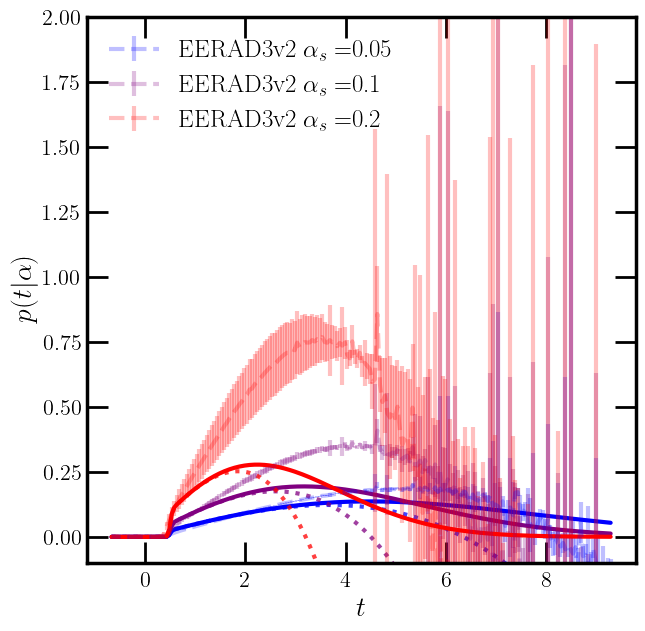

In [11]:
data_dict, t_bins, t_bin_centers = read_in_data_JAX("thrust", m)

alpha_keys = np.array(list(data_dict.keys()))
alpha_keys_float = list(data_dict.keys())

t_min = jnp.min(t_bins)
t_max = jnp.max(t_bins)


# Keys of interest
keys = np.array([0.05, 0.1, 0.2])

# Find the keys in the list closest to these values (to deal with floating point errors)
for (k, key) in enumerate(keys):

    closest_key = alpha_keys_float[np.argmin(np.abs(key - alpha_keys))]
    keys[k] = closest_key


# Make an array of ys and yerrs so we dont have to keep the dictionary around
ys = []
yerrs = []
for key in alpha_keys_float:
    y, yerr = data_dict[key]
    y = y[:,0]
    yerr = yerr[:,0]

    # clamp yerr by its nonzero minimum

    min_y_err = np.min(yerr[yerr > 0])
    yerr = np.clip(yerr, a_min=min_y_err.item(), a_max=None)
    
    ys.append(y)
    yerrs.append(yerr)

ys = jnp.array(ys)
yerrs = jnp.array(yerrs)


# Make a plot of the data 
colors = ["blue", "purple", "red"]
fig, ax = newplot("full")
q_vals = q_vmap2(t_bin_centers, keys, params["g_star"], params["g_coeffs"], params["thetas"])
q_taylor_vals = CHOSEN_Q_VMAP2(t_bin_centers, keys, params["g_star"], params["g_coeffs"], params["thetas"])

for (k, key) in enumerate(keys):
    y, yerr = data_dict[key]
    y = y[:,0]
    yerr = yerr[:,0]
    plt.errorbar(t_bin_centers, y, yerr, color = colors[k], ls = "--", alpha = 0.25 ,label = r"EERAD3v2 $\alpha_s = $" + f"{key}")
    plt.plot(t_bin_centers, q_vals[k], color = colors[k])
    plt.plot(t_bin_centers, q_taylor_vals[k], color = colors[k], alpha = 0.75, ls = "dotted")

plt.ylim(-0.1, 2)
# plt.xscale("log")
plt.xlabel(r"$t$")
plt.ylabel(r"$p(t | \alpha)$")
plt.legend(loc = "upper left")



# Loss and Training

In [12]:
# Set up the loss as a function of the parameters

loss_epsilon = 1e-12

# Weighted MSE
@jax.jit
def loss_function(params):

    y_preds = jnp.nan_to_num(CHOSEN_Q_VMAP2(t_bin_centers, alpha_keys, params["g_star"], params["g_coeffs"], params["thetas"]))
    mean_errors = jnp.mean(yerrs)
    y_errs_rescaled = yerrs / mean_errors

    return jnp.mean((y_preds - ys)**2 /(y_errs_rescaled**2 + loss_epsilon)) / 2


print("Initial Loss: ", loss_function(params))


Initial Loss:  3767.1426


### Projector

Function to make sure that the polynomial's final coefficients always have the correct sign

In [13]:
def project(params):

    g_star = params["g_star"]
    g_coeffs = params["g_coeffs"]

    g_star = g_star.at[:, -1].set(-jnp.abs(g_star[:, -1]))
    g_coeffs = g_coeffs.at[:, -1].set(-jnp.abs(g_coeffs[:, -1]))

    params["g_star"] = g_star
    params["g_coeffs"] = g_coeffs

    return params

### BOGO Initializer

In [14]:
bogo_epochs = 5000

best_loss = loss_function(params)
best_params = params.copy()

factorials = np.ones_like(params["g_star"])
for mi in range(params["g_star"].shape[0]):
    for ni in range(params["g_star"].shape[1]):
        factorials[mi, ni] = 1 / math.factorial(mi + mstar) / math.factorial(ni)

counter = 0
for epoch in range(bogo_epochs):

    scale = (bogo_epochs - epoch) / bogo_epochs

    loss = loss_function(params)
    if loss < best_loss:
        best_loss = loss
        best_params = params.copy()
        counter += 1

    else:

        # Initialize params
        jax_key, subkey1, subkey2, subkey3 = jax.random.split(jax_key, 4)

        g_star = np.random.normal(loc = best_params["g_star"], size = params["g_star"].shape, scale = factorials / (np.sqrt(counter) + 1) * scale / 10) 
        g_coeffs = np.random.normal(loc = best_params["g_coeffs"], size = params["g_coeffs"].shape, scale = factorials / (np.sqrt(counter) + 1) * scale / 10)  

        # Choose signs nicely
        for ni in range(g_star.shape[1]):

            if n % 2 == 0:
                g_star[:,n] = np.abs(g_star[:,n])
                g_coeffs[:,n] = np.abs(g_coeffs[:,n])
            else:
                g_star[:,n] = -np.abs(g_star[:,n])
                g_coeffs[:,n] = -np.abs(g_coeffs[:,n])


        thetas = params["thetas"]
        thetas = np.random.normal(loc = best_params["thetas"], scale = 1 / (np.sqrt(counter) + 1) * scale / 10) 

        params = {
            "g_star" : g_star,
            "g_coeffs" : g_coeffs,
            "thetas" : thetas,
        }

    print("BOGO Epoch", epoch, "Loss =", loss, "Best Loss =", best_loss, "Counter =", counter)

params = best_params.copy()
print(params)



BOGO Epoch 0 Loss = 3767.1426 Best Loss = 3767.1426 Counter = 0
BOGO Epoch 1 Loss = 1823.7537 Best Loss = 1823.7537 Counter = 1
BOGO Epoch 2 Loss = 1823.7537 Best Loss = 1823.7537 Counter = 1
BOGO Epoch 3 Loss = 1237.8132 Best Loss = 1237.8132 Counter = 2
BOGO Epoch 4 Loss = 1237.8132 Best Loss = 1237.8132 Counter = 2
BOGO Epoch 5 Loss = 1765.8802 Best Loss = 1237.8132 Counter = 2
BOGO Epoch 6 Loss = 2990.8318 Best Loss = 1237.8132 Counter = 2
BOGO Epoch 7 Loss = 1669.4921 Best Loss = 1237.8132 Counter = 2
BOGO Epoch 8 Loss = 1615.4426 Best Loss = 1237.8132 Counter = 2
BOGO Epoch 9 Loss = 1311.4769 Best Loss = 1237.8132 Counter = 2
BOGO Epoch 10 Loss = 1800.9281 Best Loss = 1237.8132 Counter = 2
BOGO Epoch 11 Loss = 1451.3204 Best Loss = 1237.8132 Counter = 2
BOGO Epoch 12 Loss = 1081.324 Best Loss = 1081.324 Counter = 3
BOGO Epoch 13 Loss = 1081.324 Best Loss = 1081.324 Counter = 3
BOGO Epoch 14 Loss = 1646.747 Best Loss = 1081.324 Counter = 3
BOGO Epoch 15 Loss = 1024.446 Best Loss =

### Real Training

Note due to compilation, epoch 1 should take a long time, but every subsequent epoch should be faster

In [15]:
params = best_params.copy()


  0%|          | 0/5000 [00:00<?, ?it/s]

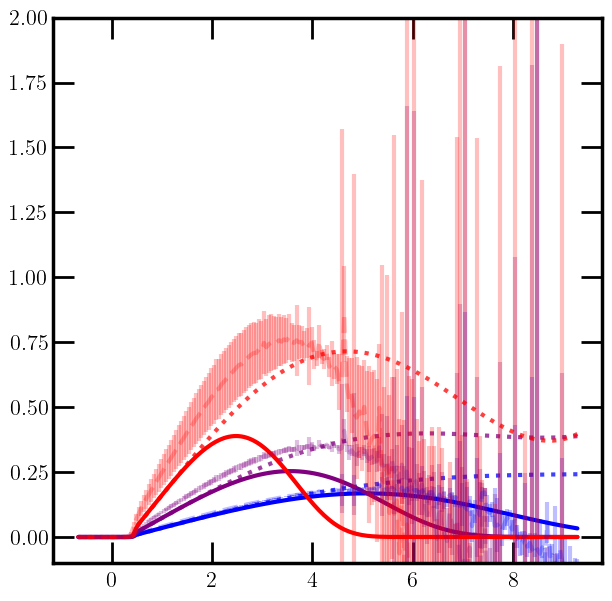

 9.5341:   2%|▏         | 100/5000 [00:31<16:40,  4.90it/s]  

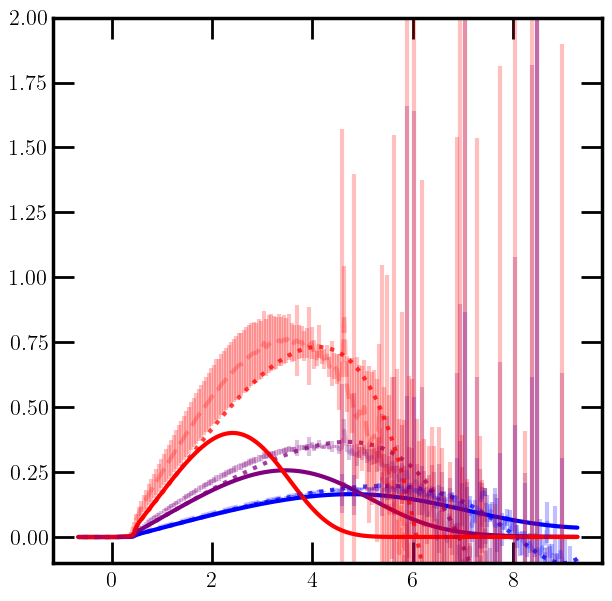

 8.2235:   4%|▍         | 200/5000 [00:50<14:10,  5.64it/s]

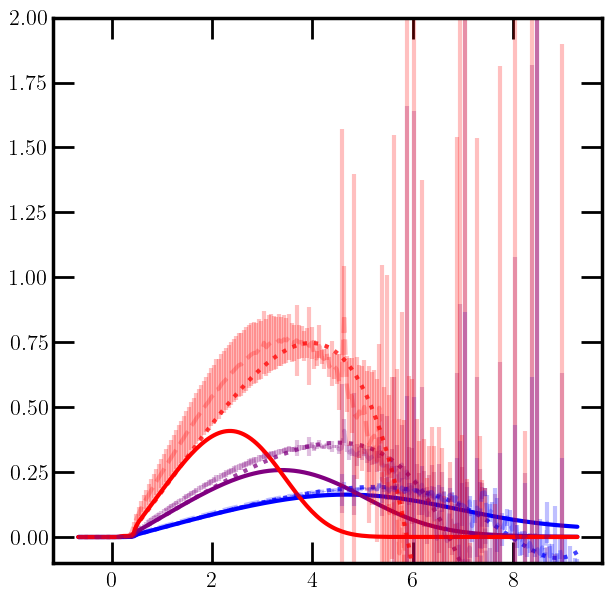

 7.2436:   6%|▌         | 300/5000 [01:10<16:11,  4.84it/s]

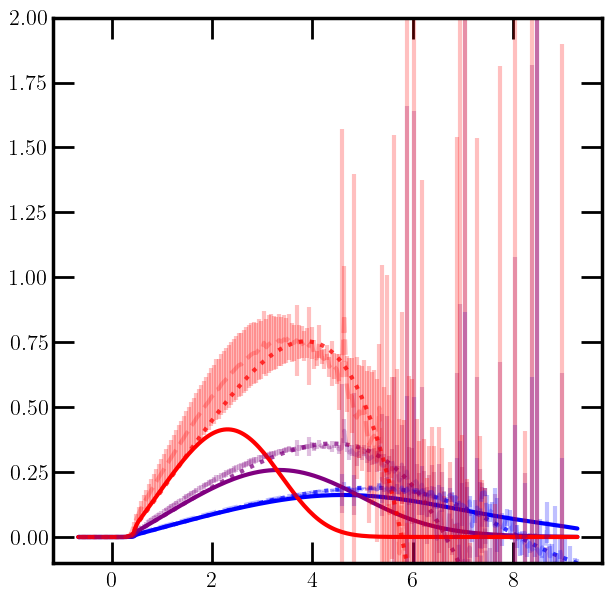

 6.4134:   8%|▊         | 400/5000 [01:31<14:30,  5.28it/s]

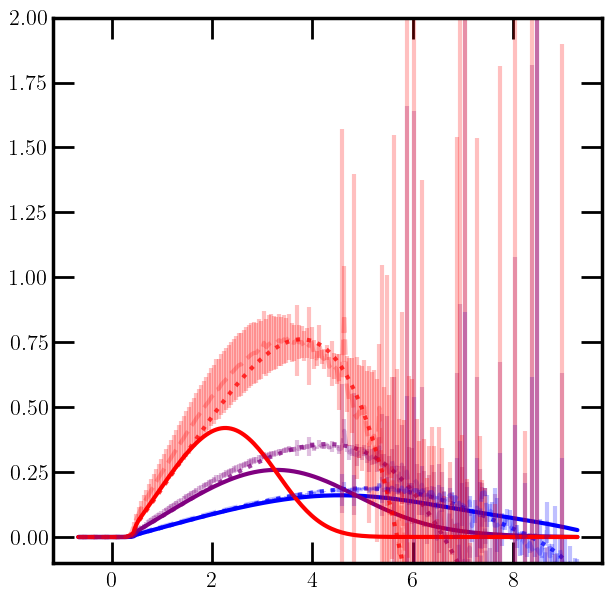

 5.7973:  10%|█         | 500/5000 [01:53<15:03,  4.98it/s]

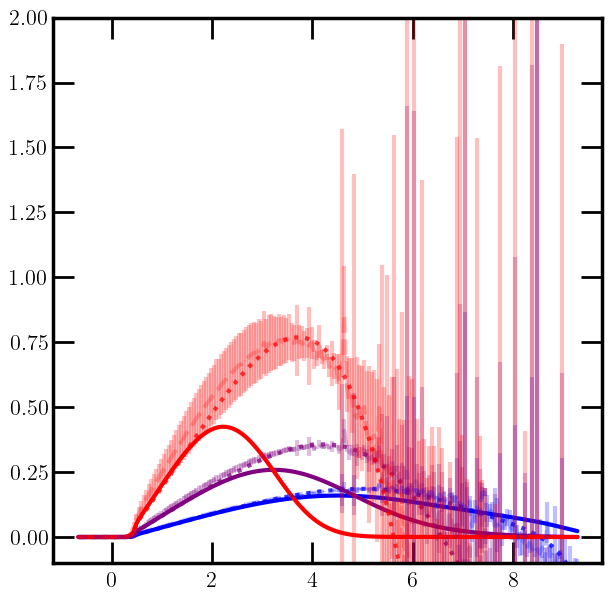

 5.3445:  12%|█▏        | 600/5000 [02:13<15:16,  4.80it/s]

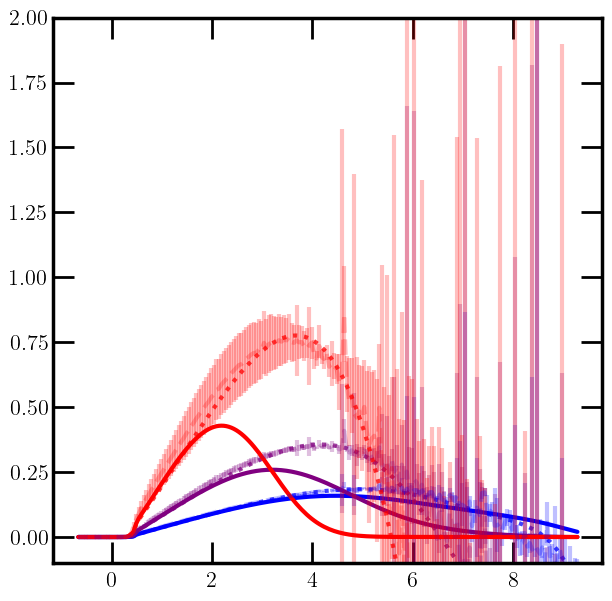

 5.0044:  14%|█▍        | 700/5000 [02:33<12:40,  5.65it/s]

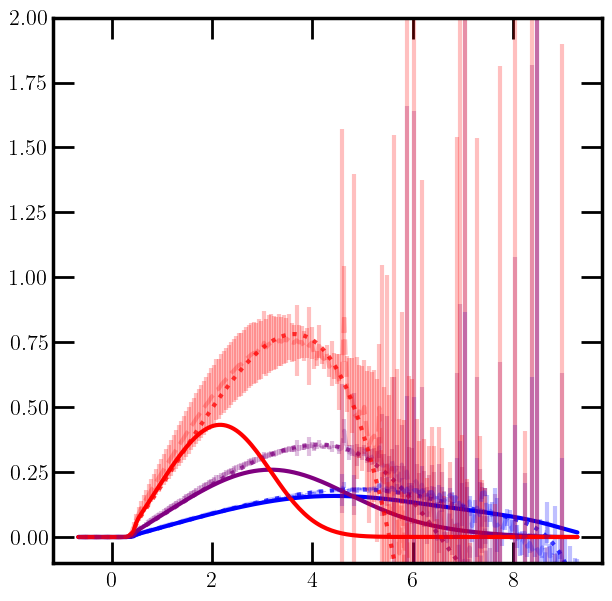

 4.7469:  16%|█▌        | 800/5000 [02:54<13:23,  5.23it/s]

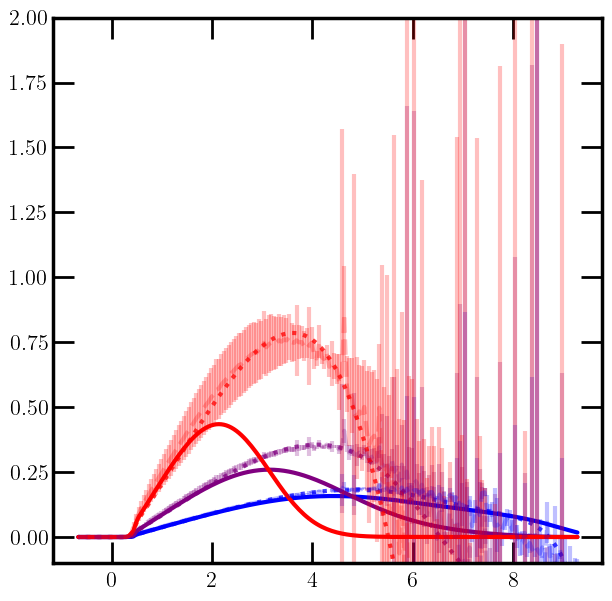

 4.5201:  18%|█▊        | 900/5000 [03:12<11:41,  5.84it/s]

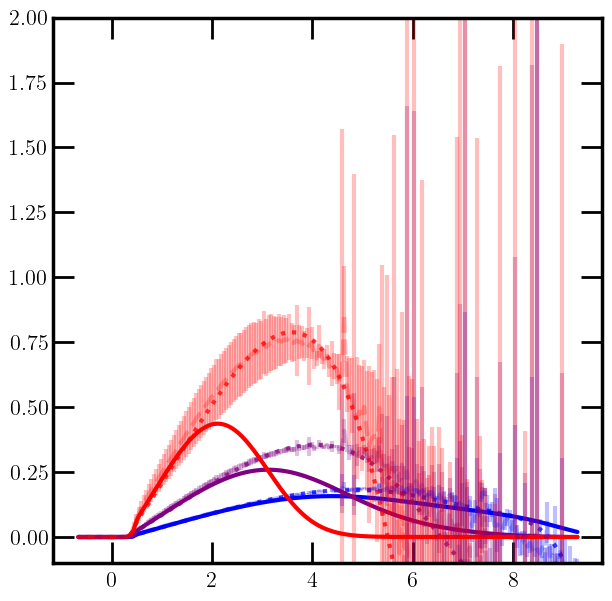

 4.3311:  20%|██        | 1000/5000 [03:32<12:36,  5.29it/s]

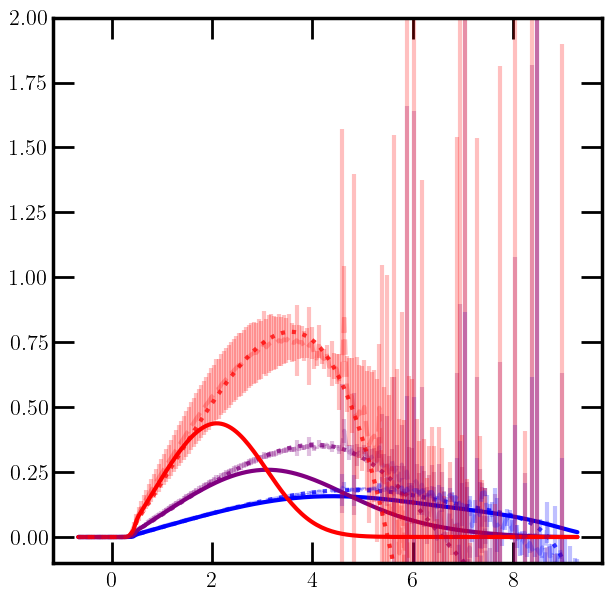

 4.2184:  22%|██▏       | 1100/5000 [03:52<11:23,  5.71it/s]

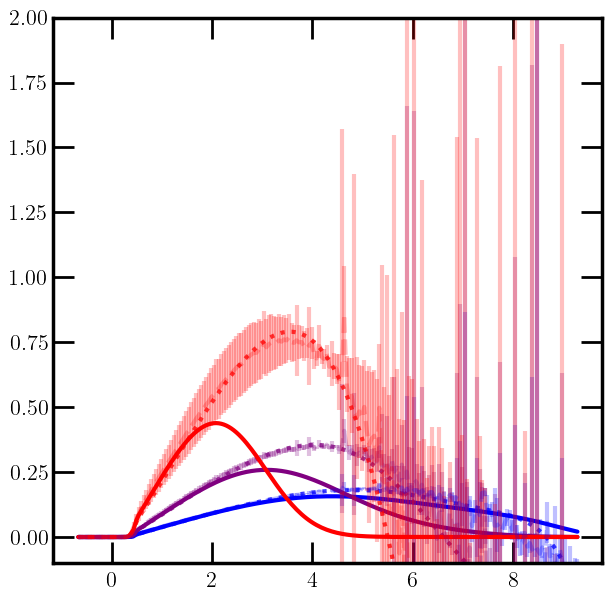

 4.0112:  24%|██▍       | 1200/5000 [04:13<12:13,  5.18it/s]

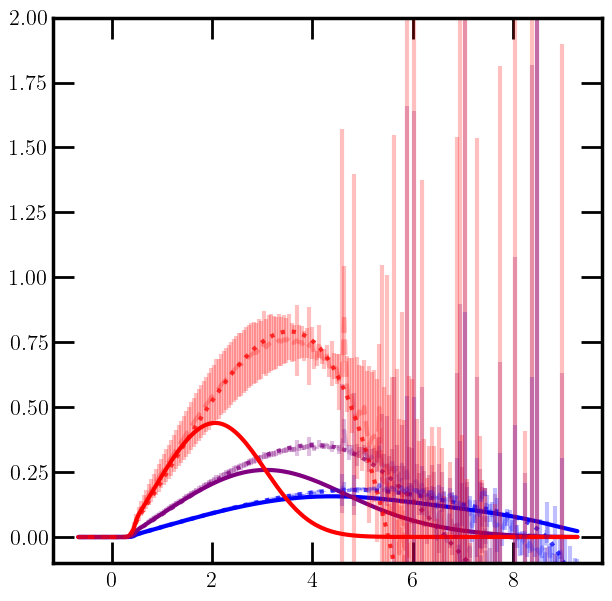

 3.8708:  26%|██▌       | 1300/5000 [04:38<11:54,  5.18it/s]

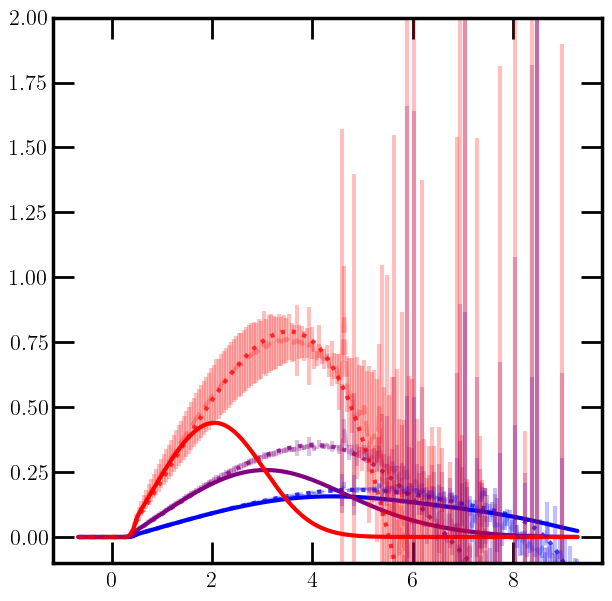

 3.7394:  28%|██▊       | 1400/5000 [05:00<12:44,  4.71it/s]

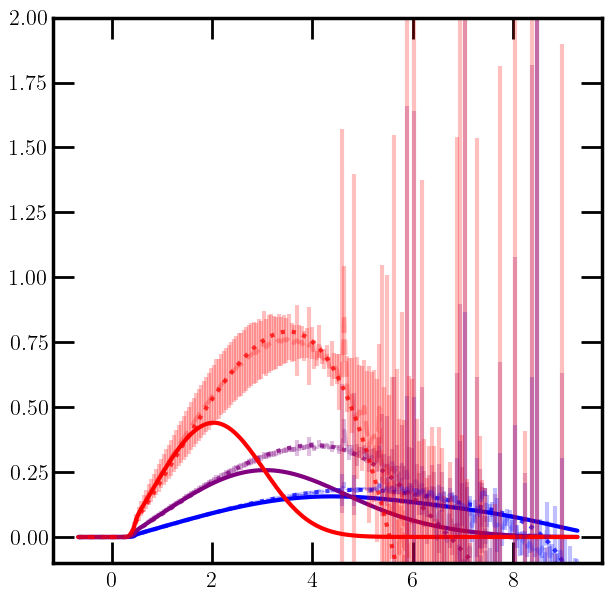

 3.6888:  30%|███       | 1500/5000 [05:23<15:54,  3.67it/s]

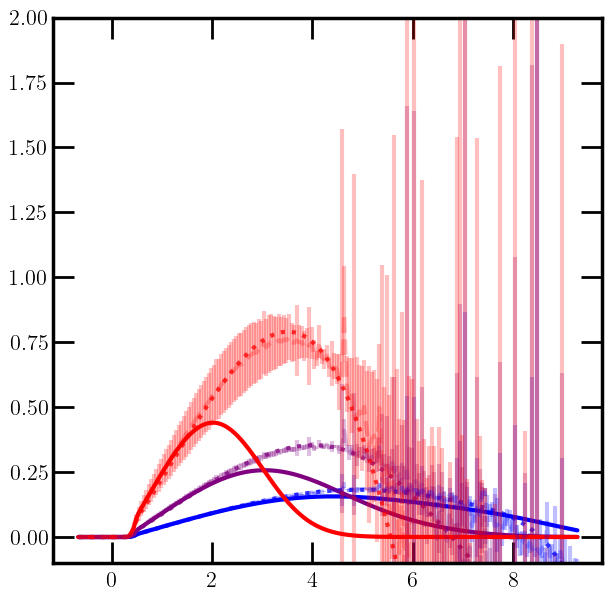

 60480.3672:  32%|███▏      | 1600/5000 [05:47<12:20,  4.59it/s]

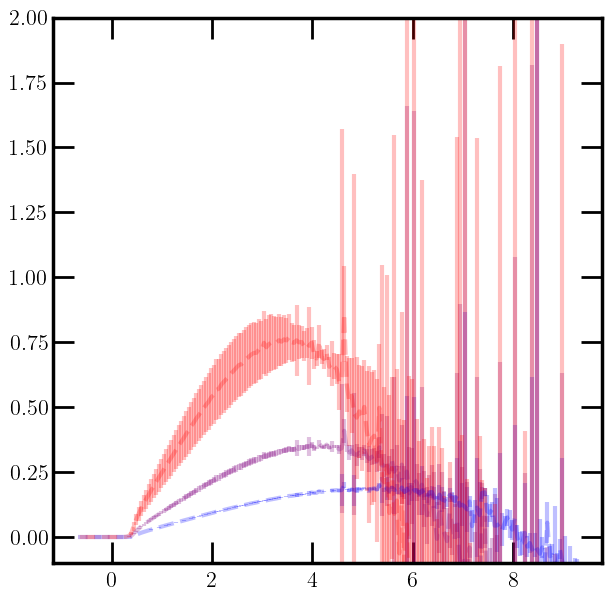

 60480.3672:  34%|███▍      | 1700/5000 [06:09<11:50,  4.65it/s]

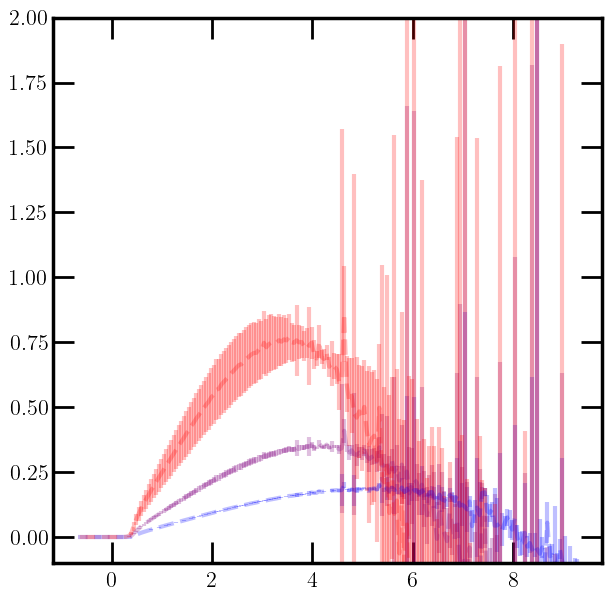

 60480.3672:  36%|███▌      | 1800/5000 [06:31<09:55,  5.38it/s]

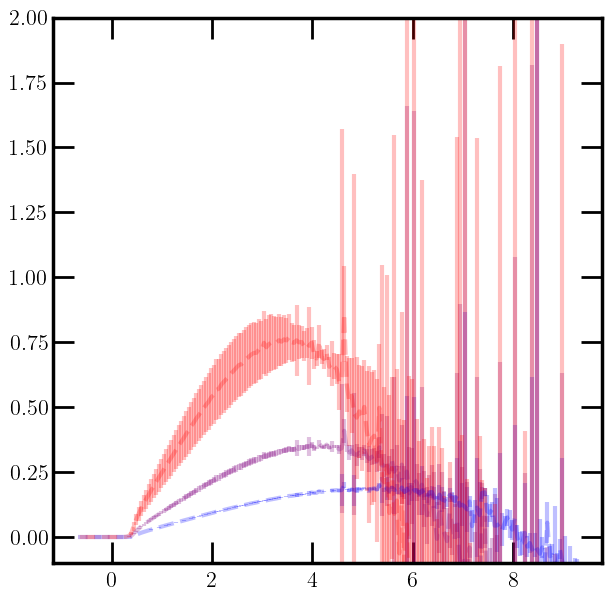

 60480.3672:  38%|███▊      | 1900/5000 [06:52<08:38,  5.98it/s]

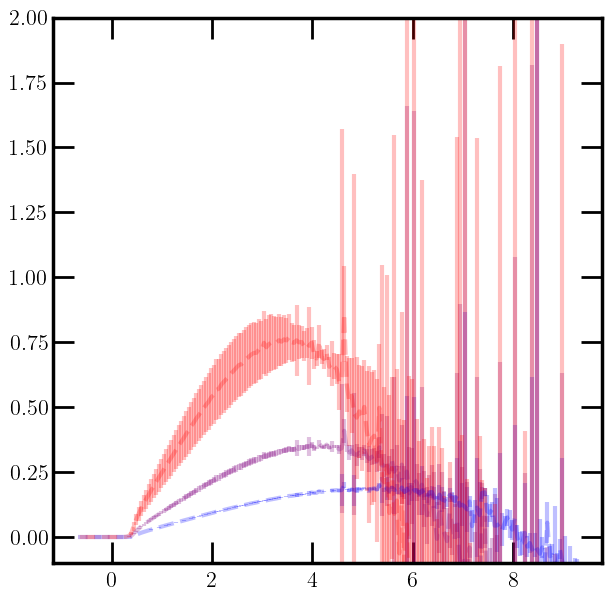

 60480.3672:  40%|████      | 2000/5000 [07:13<08:43,  5.73it/s]

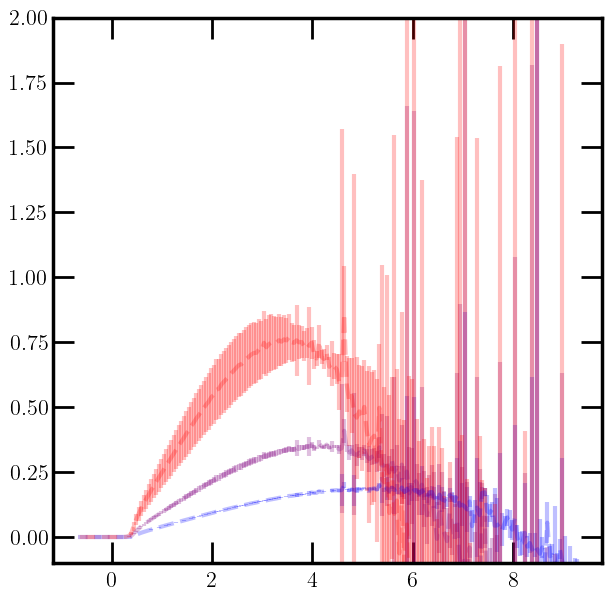

 60480.3672:  40%|████      | 2022/5000 [07:19<10:47,  4.60it/s]


KeyboardInterrupt: 

In [ ]:
# Initialize Optimizer
opt = optax.adamw(lr  , weight_decay= weight_decay)
opt_state = opt.init(params)

# Initialize logs
losses = []
params_log = []
params_log.append(params)
g_coeffs_log = [params["g_coeffs"]]
g_star_log = [params["g_star"]]
thetas_log = [params["thetas"]]

# @jax.jit
def train_step(epoch, params, opt_state, random_key):
    
    # Boilerplate, in case we need random numbers
    key, subkey = jax.random.split(random_key)

    # Get the gradients
    loss, grad_loss = jax.value_and_grad(loss_function)(params)

    # Jax Grad Descent stuff
    updates, opt_state = opt.update(grad_loss, opt_state, params=params)
    params = optax.apply_updates(params, updates)

    

    # Save the random key for the seed for the next epoch
    return params, opt_state, loss, subkey

# Loop
epochs_tqdm = tqdm(range(epochs))
for epoch in epochs_tqdm:



    if epoch % 100 == 0:
        fig, ax = newplot("full")
        q_vals = q_vmap2(t_bin_centers, keys, params["g_star"], params["g_coeffs"], params["thetas"])
        q_taylor_vals = CHOSEN_Q_VMAP2(t_bin_centers, keys, params["g_star"], params["g_coeffs"], params["thetas"])

        for (k, key) in enumerate(keys):
            y, yerr = data_dict[key]
            y = y[:,0]
            yerr = yerr[:,0]
            plt.errorbar(t_bin_centers, y, yerr, color = colors[k], ls = "--", alpha = 0.25 ,label = r"EERAD3v2 $\alpha_s = $" + f"{key}")
            plt.plot(t_bin_centers, q_vals[k], color = colors[k])
            plt.plot(t_bin_centers, q_taylor_vals[k], color = colors[k], alpha = 0.75, ls = "dotted")


        plt.ylim(-0.1, 2e0)
        plt.show()


    # Train Step
    params, opt_state, loss, jax_key = train_step(epoch, params, opt_state, jax_key)


    # Project the params to make them physical
    params = project(params)
    # print(params)

    losses.append(loss)
    g_star_log.append(params['g_star'])
    g_coeffs_log.append(params['g_coeffs'])
    thetas_log.append(params['thetas'])
    params_log.append(params)


    epochs_tqdm.set_description(f"{losses[-1].item() : .4f}")
    # print(g_coeffs_log[-1])
    # print(g_star_log[-1])
    # print(thetas_log[-1])





/tmp/ipykernel_174531/1215073456.py:7: RuntimeWarning: invalid value encountered in log
  g_coeffs_log = np.log(g_coeffs_log)


Text(0.5, 0, 'epochs')

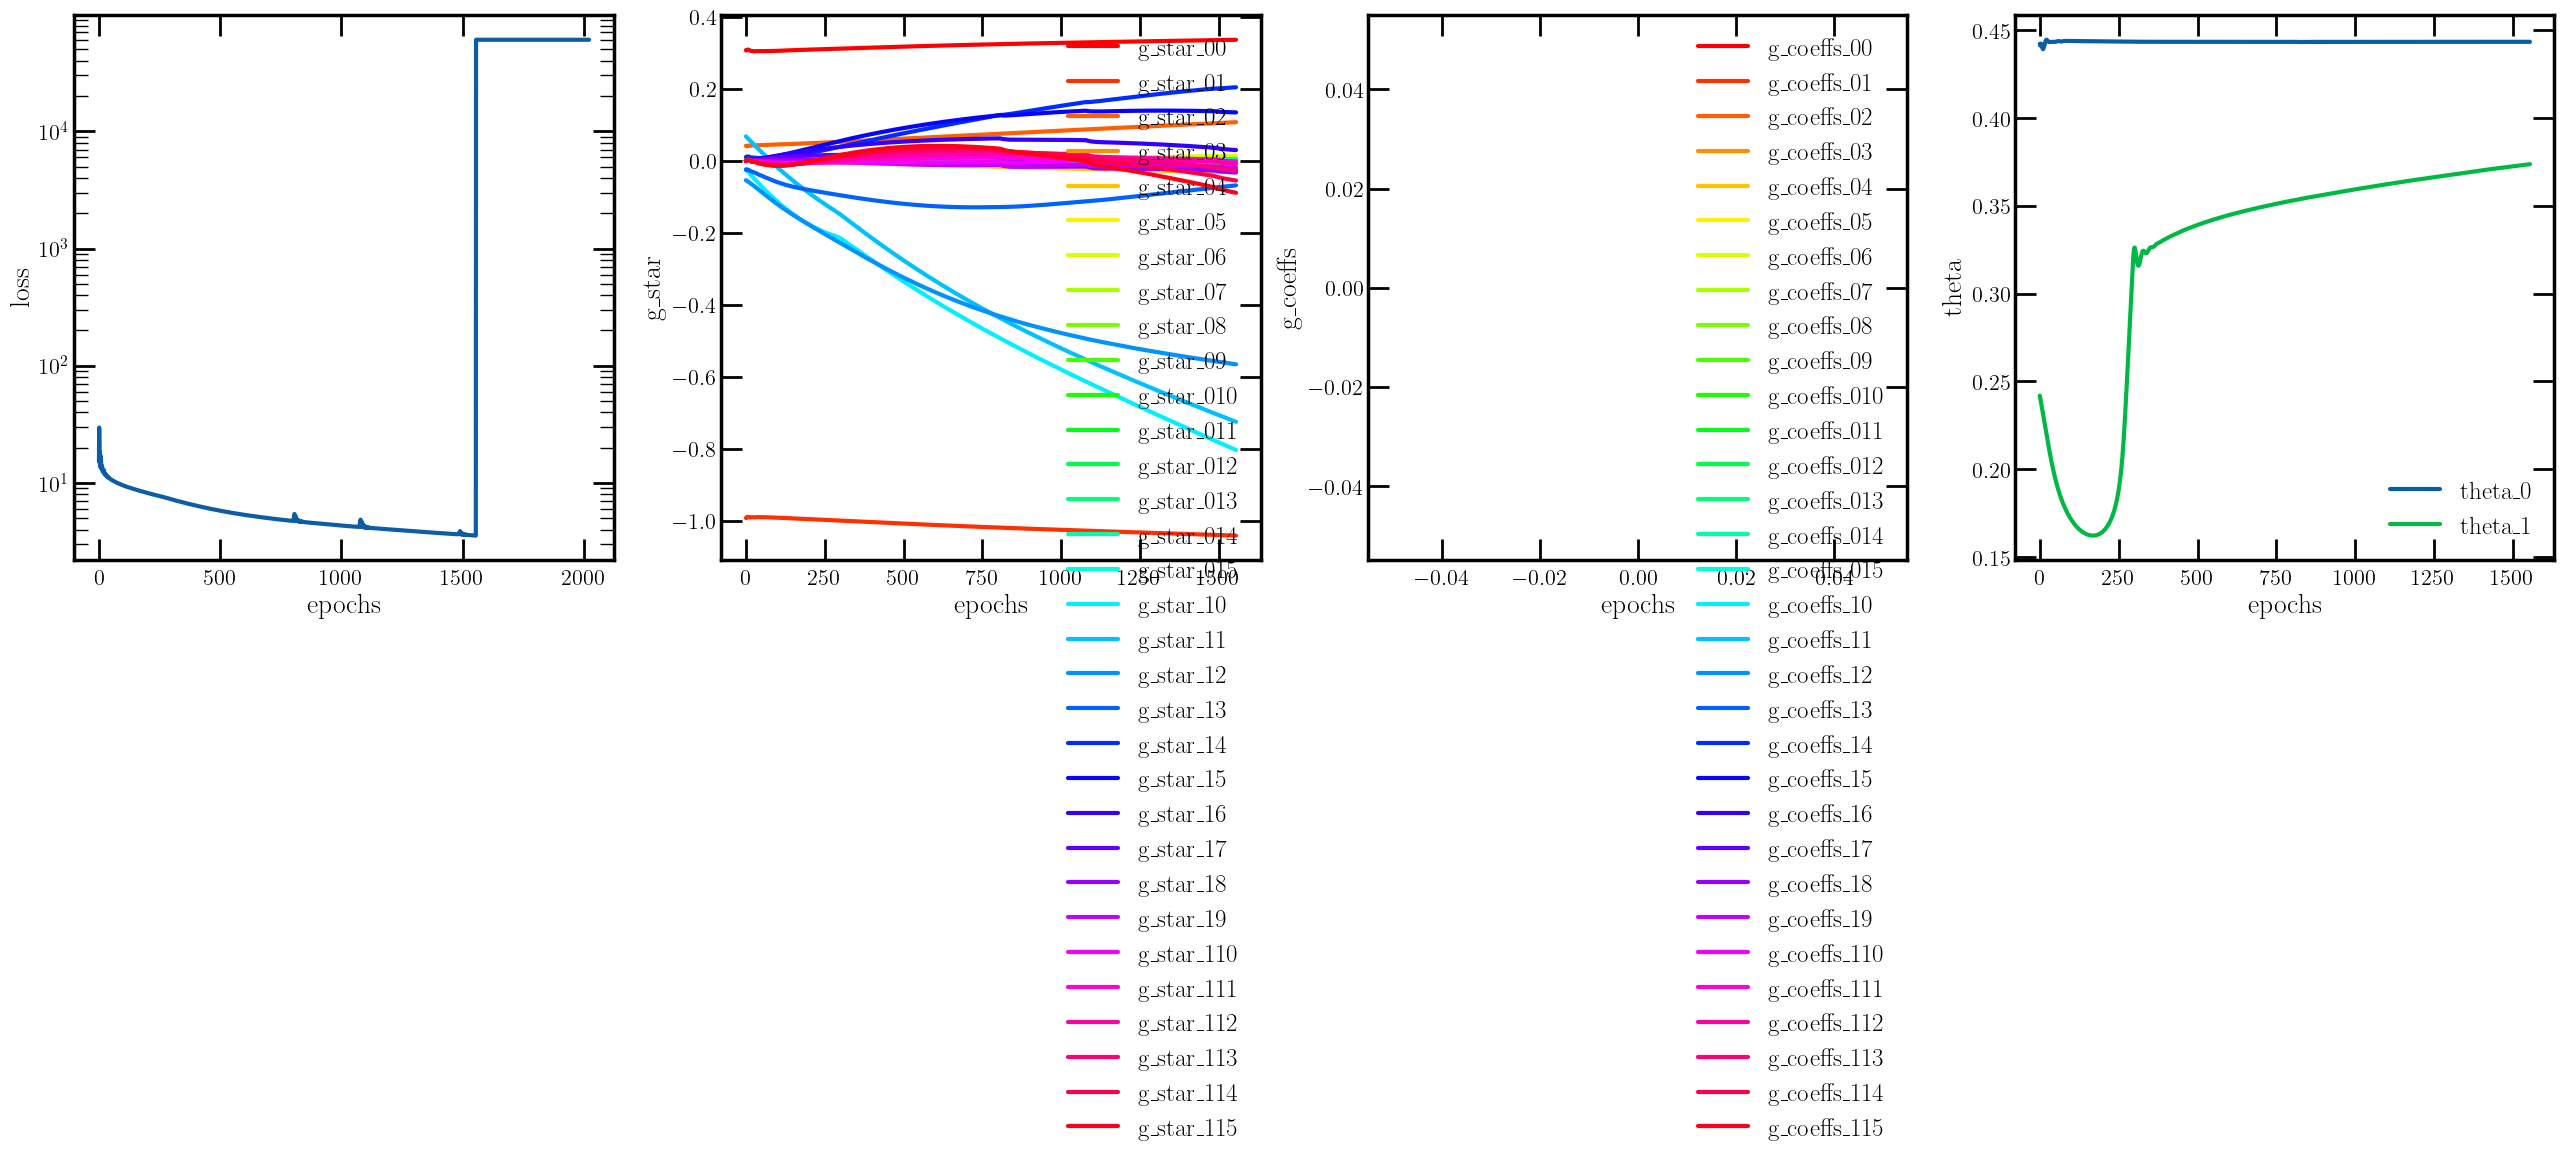

In [19]:
from matplotlib.pyplot import cm

fig, ax = newplot("full", width = 8 * 4, subplot_array=(1, 4))

losses = np.array(losses)
g_star_log = np.array(g_star_log)
g_coeffs_log = np.log(g_coeffs_log)
thetas_log = np.array(thetas_log)


color = iter(
    cm.hsv(np.linspace(0, 1, g_coeffs_log.shape[1] * g_coeffs_log.shape[2]))
)


ax[0].plot(losses)
ax[0].set_yscale("log")

for mi in range(g_star_log.shape[1]):

    ax[3].plot(thetas_log[:,mi], label = f"theta_{mi}")

    for ni in range(g_star_log.shape[2]):

        c = next(color)

        ax[1].plot(g_star_log[:,mi,ni], color = c, label = f"g_star_{mi}{ni}")
        ax[2].plot(g_coeffs_log[:,mi,ni], color = c, label = f"g_coeffs_{mi}{ni}")

ax[0].set_ylabel("loss")
ax[0].set_xlabel("epochs")

ax[1].legend()
ax[1].set_ylabel("g_star")
ax[1].set_xlabel("epochs")

ax[2].legend()
ax[2].set_ylabel("g_coeffs")
ax[2].set_xlabel("epochs")

ax[3].legend()
ax[3].set_ylabel("theta")
ax[3].set_xlabel("epochs")

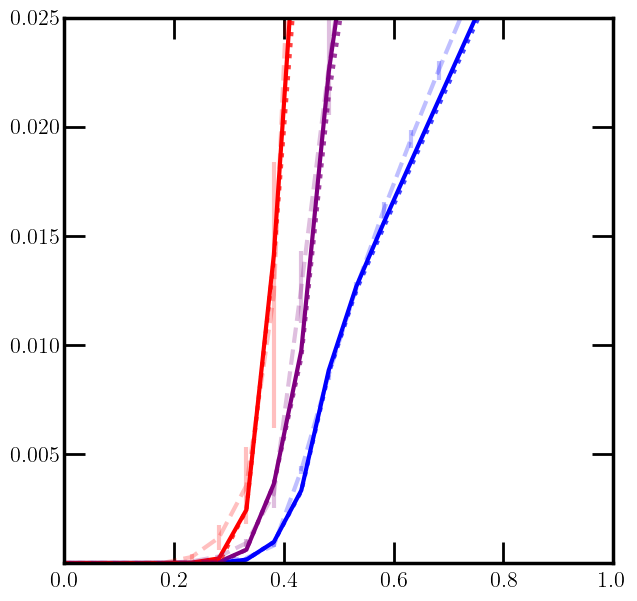

{'g_coeffs': Array([[-1.1879270e+00, -1.1048813e+00, -3.3897266e-01,  1.2902182e-01,
         1.2310261e-01,  4.6760156e-03, -4.9232211e-02, -4.7622669e-02,
        -2.0464506e-02,  8.8480031e-03,  2.8548690e-02,  3.4708209e-02,
         2.7524287e-02,  8.9497278e-03, -1.8552870e-02, -5.2587591e-02],
       [ 4.7743913e-02, -6.7373373e-02,  2.2130175e-02, -1.8607059e-03,
        -2.0671077e-03,  2.5203915e-03,  9.2533795e-05, -1.7768325e-05,
        -3.6816560e-05,  8.3032983e-06,  4.7195248e-05,  5.5812565e-05,
         4.0826522e-05,  1.8332661e-05,  2.7818643e-07, -9.2643695e-06]],      dtype=float32), 'g_star': Array([[ 3.35313767e-01, -1.03974009e+00,  1.04853995e-01,
        -7.81618804e-03, -3.14202197e-02, -2.36242078e-04,
         1.33481594e-02,  6.52998872e-03, -2.43771146e-03,
        -5.46729984e-03, -3.52095370e-03,  2.41964357e-04,
         3.23730335e-03,  3.98037396e-03,  1.85076345e-03,
        -3.23833851e-03],
       [-7.82642841e-01, -7.06835806e-01, -5.58601677e-0

In [22]:
fig, ax = newplot("full")

params = params_log[1500]

q_vals = q_vmap2(t_bin_centers, keys, params["g_star"], params["g_coeffs"], params["thetas"])
q_taylor_vals = CHOSEN_Q_VMAP2(t_bin_centers, keys, params["g_star"], params["g_coeffs"], params["thetas"])

for (k, key) in enumerate(keys):
    y, yerr = data_dict[key]
    y = y[:,0]
    yerr = yerr[:,0]
    plt.errorbar(t_bin_centers, y, yerr, color = colors[k], ls = "--", alpha = 0.25 ,label = r"EERAD3v2 $\alpha_s = $" + f"{key}")
    plt.plot(t_bin_centers, q_vals[k], color = colors[k])
    plt.plot(t_bin_centers, q_taylor_vals[k], color = colors[k], alpha = 0.75, ls = "dotted")

plt.xlim(0, 1)
plt.ylim(0.000001, 0.025)
# plt.xscale("log")
# plt.yscale("log")
plt.show()

print(params)


0.07505126
0.18686917
0.18685372


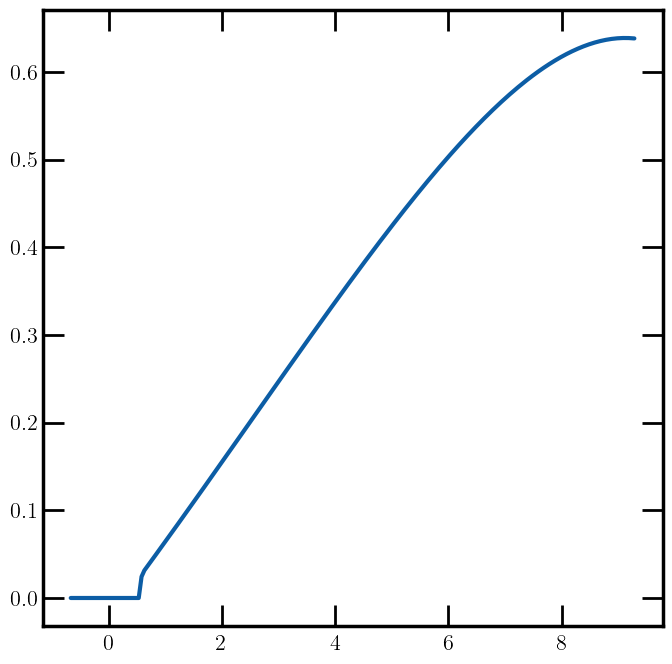

In [ ]:
print(loss_function(params_log[0]))
print(loss_function(params_log[1]))
print(loss_function(params_log[2]))

y_preds = CHOSEN_Q_VMAP2(t_bin_centers, keys, params_log[1]["g_star"], params_log[1]["g_coeffs"], params_log[1]["thetas"])
y_preds = jnp.nan_to_num(y_preds)

y_preds = CHOSEN_Q_VMAP2(t_bin_centers, keys, params_log[1]["g_star"], params_log[1]["g_coeffs"], params_log[1]["thetas"])
plt.plot(t_bin_centers, y_preds[1])